# Gyral sulcal differences map

In [1]:
%cd work/notebooks

/home/jovyan/work/notebooks


In [2]:
# Import modules and R
import numpy as np, pandas as pd
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

In [9]:
# Import local code
import sys
sys.path.append('../code')
from gradientVersion import *
from processing_helpers import *
from analysis_helpers import *
from mri_maps import *
%R source("../code/Rplots.R");
%R source("../code/brainPlots.R");
%R source("../code/plot_maps.R");

In [4]:
dm_hcp_ds8 = gradientVersion().fit('hcp_ds8')
scores_ds8 = dm_hcp_ds8.clean_scores()

dm_hcp_3d_ds5 = gradientVersion().fit('hcp_3donors_ds5')
scores_ds5 = dm_hcp_3d_ds5.clean_scores()

New gradients version: method=dm, params={'alpha': 1}, kernel=normalized_angle, sparsity=0, data=hcp_ds8
New gradients version: method=dm, params={'alpha': 1}, kernel=normalized_angle, sparsity=0, data=hcp_3donors_ds5


In [5]:
hcp_scores = pd.concat({'DS8': scores_ds8, '3+ DS5': scores_ds5}).reset_index(0).rename({'level_0':'version'}, axis=1)

In [6]:
# Load gyral sulcal diff data
import nibabel as nib
scz_diff_img = nib.load('../data/lh.GyralSulcalDifferences.mgh')

In [7]:
# Parcellate and label
from neuromaps.nulls.spins import parcels_to_vertices, vertices_to_parcels

hcp_img_path = '../data/parcellations/lh.HCPMMP1.annot'
hcp_img = annot_to_gifti(hcp_img_path)

scz_diff_hcp = vertices_to_parcels(scz_diff_img.get_fdata(), hcp_img)

In [28]:
from neuromaps.images import annot_to_gifti
from neuromaps.nulls.spins import parcels_to_vertices, vertices_to_parcels

hcp_img = annot_to_gifti("../data/parcellations/lh.HCPMMP1.annot")
dk_img = annot_to_gifti("../data/parcellations/lh.aparc.annot")

# Use HCP parcellation image to project HCP data to fsaverage
g_fsaverage = parcels_to_vertices(scz_diff_hcp, hcp_img)
# Use DK parcellation image to project fsaverage data into DK
g_dk = vertices_to_parcels(g_fsaverage, dk_img)

NameError: name 'scores_dk' is not defined

In [39]:
# get_labels_dk()
# scz_diff_dk = pd.DataFrame({'scz_diff':g_dk}, index=get_labels_dk()[:34])
# scz_diff_dk
get_disorder_maps().join(scz_diff_dk).corr()

,AD,ADHD,ANX,ASD,MCI,MDD,SCZ,scz_diff
AD,1.000000,-0.221548,-0.060258,0.403749,0.904888,-0.051891,0.199879,0.418841
ADHD,-0.221548,1.000000,0.052947,-0.140695,-0.129266,-0.203731,-0.167058,-0.107729
ANX,-0.060258,0.052947,1.000000,-0.137977,-0.077950,0.369321,-0.167477,-0.186147
ASD,0.403749,-0.140695,-0.137977,1.000000,0.454616,-0.209068,-0.009396,0.053017
MCI,0.904888,-0.129266,-0.077950,0.454616,1.000000,-0.044469,0.135508,0.365332
MDD,-0.051891,-0.203731,0.369321,-0.209068,-0.044469,1.000000,0.070487,0.085667
SCZ,0.199879,-0.167058,-0.167477,-0.009396,0.135508,0.070487,1.000000,0.658137
scz_diff,0.418841,-0.107729,-0.186147,0.053017,0.365332,0.085667,0.658137,1.000000


In [8]:
scz_diff = get_labels_hcp()[:180].to_frame().assign(scz_diff = scz_diff_hcp).set_index('label')
# scz_diff = scz_diff.assign(scz_diff_norm = lambda x: x[['scz_diff']].apply(lambda y: (y-np.mean(y))/np.std(y)))
# scz_diff

In [21]:
scz_diff_scatter = scz_diff \
    .join(scores_ds5.set_index('label')).reset_index() \
    .melt(id_vars=['label','scz_diff'], var_name='G', value_name='G_score') \
    .rename({'scz_diff':'map_score'}, axis=1).assign(map='scz_diff')
# scz_diff_scatter

In [23]:
# nulls = np.load('../outputs/permutations/hcp_ds8_spin_1000.npy')
nulls = np.load('../outputs/permutations/hcp_3d_ds5_spin_1000.npy')
null_corrs = corr_nulls_from_grads(nulls, scores_ds5, scz_diff)

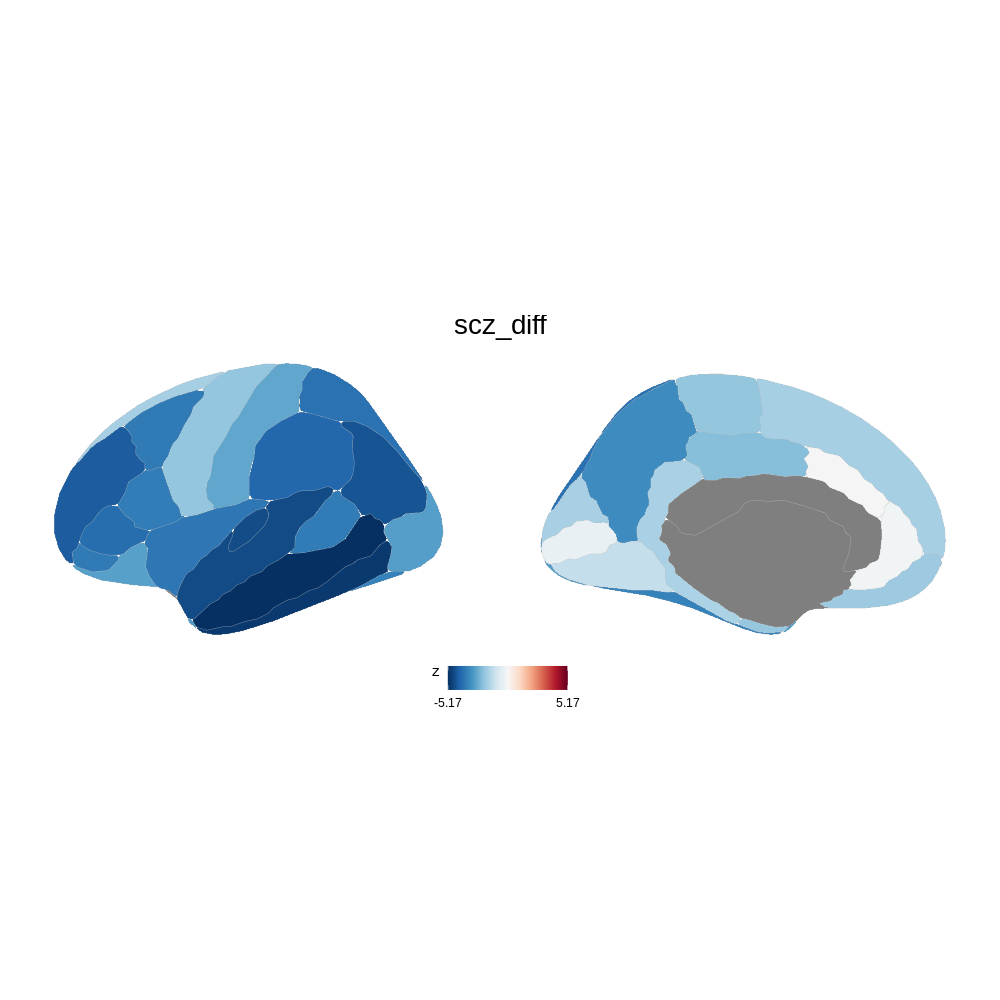

In [35]:
%%R -w 10 -h 10 --units in -r 100 -i scz_diff -i hcp_scores -i scz_diff_scatter -i scz_diff_dk

# g1 = plot_maps(scz_diff, ncol=1) 
# g2 = plot_hcp(hcp_scores)
plot_maps_dk(scz_diff_dk)

# (g1 / g2) + plot_layout(heights=c(1,2)) & theme(text=element_text(size=16))
# g3 & theme(text=element_text(size=16))

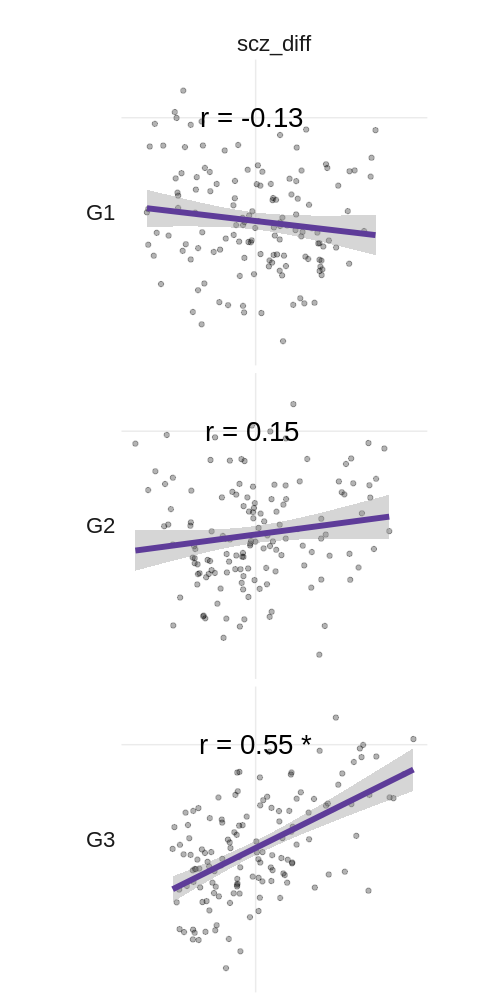

In [88]:
%%R -w 5 -h 10 --units in -r 100 -i scz_diff -i hcp_scores -i scz_diff_scatter -i scz_diff_null_p
g3 = plot_maps_scatter(scz_diff_scatter, scz_diff_null_p, size=7, facet='h')
g3 & theme(text=element_text(size=16))

In [13]:
nulls_ds8 = {
    'ds8_sim_5000': np.load("../outputs/permutations/hcp_ds8_sim_5000.npy"),
    'ds8_spin_5000': np.load("../outputs/permutations/hcp_ds8_spin_5000.npy")
}

nulls_ds5 = {
    'ds5_sim_5000': np.load("../outputs/permutations/hcp_3d_ds5_sim_5000.npy"),
    'ds5_spin_5000': np.load("../outputs/permutations/hcp_3d_ds5_spin_5000.npy")
}

In [14]:
null_corrs_dict_ds8 = {name: corr_nulls_from_grads(nulls[:,:,:], scores_ds8, scz_diff) for name, nulls in nulls_ds8.items()}
null_corrs_dict_ds5 = {name: corr_nulls_from_grads(nulls[:,:,:], scores_ds5, scz_diff) for name, nulls in nulls_ds5.items()}

In [15]:
null_corrs_dict = {**null_corrs_dict_ds8, **null_corrs_dict_ds5}
corr_versions = {version:stats for version, stats in null_corrs_dict.items()}
corr_versions = pd.concat(corr_versions).reset_index().set_axis(['version','G','map','r','p','q'], axis=1)

In [17]:
save_pickle(corr_versions, 'corr_versions_scz_gyral_sulcal')

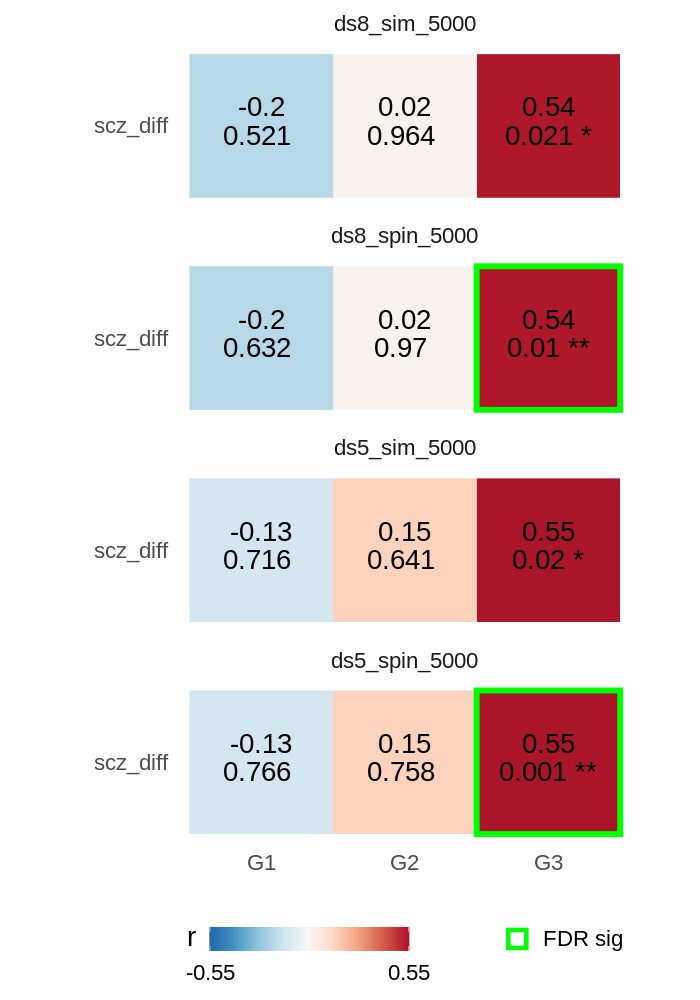

In [16]:
%%R -w 7 -h 10 --units in -r 100 -i corr_versions
source('../code/plot_maps.R')
plot_corr_versions(corr_versions, facet='w', size=7)